In [43]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

try:
    WORKING_DIR
except NameError:
    WORKING_DIR = Path.cwd().parent.parent

%cd $WORKING_DIR
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jmachadofreitas/Projects/cannabis-seed-microbiome


In [44]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
from pathlib import Path

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}

asv_table = pd.read_csv("data/FlashWeave/abundance_cultivar.csv")
asv_table = asv_table.sum(axis=0) / asv_table.sum().sum()

ecotype_table = pd.read_csv("data/umap/t_all-cultivar-ecotype.csv").set_index("ASV")

metadata = pd.read_csv("data/FlashWeave/metadata.csv").set_index("cultivar")
metadata.index = "cultivar_" + metadata.index
metadata.fillna("UNK", inplace=True)

cultivar_rel_abundance = metadata.groupby(by="cultivar").size() / len(metadata)
cultivar_rel_abundance = cultivar_rel_abundance / max(cultivar_rel_abundance)

# path = Path("outputs/FlashWeave/network_cultivar-alpha=0.05.gml")
# path = Path("outputs/FlashWeave/network_cultivar-alpha=1.0e-10.gml")
path = Path("outputs/FlashWeave/network_cultivar-alpha=1.0e-12.gml")
# path = Path("outputs/FlashWeave/network_cultivar.gml")
with path.open("r") as f:
    G = nx.parse_gml(f.read())

nx.is_directed(G)

False

In [48]:
from networkx.algorithms.community import greedy_modularity_communities

for u, v in G.edges():
    weight = G[u][v]['weight']
    G[u][v]['abs_weight'] = abs(weight)

communities = greedy_modularity_communities(G, weight="abs_weight")
print("Number of communities:",  len(communities))

Number of communities: 189


In [49]:
community_dict = {}
for i, community in enumerate(communities):
    for node in community:
        if G.nodes(data=True)[node]["mv"]:
            community_dict[node] = 0  # Cultivar
        else:
            community_dict[node] = i+1
        
# Add the community information as a node attribute
nx.set_node_attributes(G, community_dict, 'community')

In [50]:
for node, props in G.nodes(data=True):
    if props["mv"]:
        props["domestication"] = metadata.loc[node, "domestication"].iloc[0]
        props["chemotype"] = metadata.loc[node, "chemotype"].iloc[0]
        props["chemotype2"] = metadata.loc[node, "chemotype2"].iloc[0]
        props["color"] = "Cultivar"
        props["rel_abundance"] = cultivar_rel_abundance[node]
    else:
        props["rel_abundance"] = asv_table.loc[node]
        props["ecotype"] = ecotype_table.loc[node, "sign"]
        props["color"] = ecotype_table.loc[node, "sign"]

nx.write_gml(G, path.parent / (path.stem + "-props.gml"))

In [34]:
hubs, authorities = nx.hits(G)
sorted(hubs.items(), key = lambda t: -t[1])[:10]

[('ASV 2191: Nocardioides', 0.03828450275159372),
 ('ASV 3103: Alistipes', 0.03828317864376166),
 ('ASV 280: Colidextribacter', 0.034867957906174016),
 ('ASV 341: Alistipes', 0.034867957906174016),
 ('ASV 569: Candidatus_Soleaferrea', 0.034867957906174016),
 ('ASV 622: Desulfovibrionaceae', 0.034867957906174016),
 ('ASV 844: Paludibacter', 0.034867957906174016),
 ('ASV 864: Flavobacterium_sp.', 0.034867957906174016),
 ('ASV 886: Desulfovibrio', 0.034867957906174016),
 ('ASV 925: Candidatus_Soleaferrea', 0.034867957906174016)]

In [35]:
sorted(authorities.items(), key = lambda t: -t[1])[:10]

[('ASV 2191: Nocardioides', 0.038284502751597387),
 ('ASV 3103: Alistipes', 0.03828317864376534),
 ('ASV 3527: Pseudomonas', 0.03486795790617679),
 ('ASV 3576: JGI_0000069-P22', 0.03486795790617679),
 ('ASV 4583: Rhodospirillales', 0.03486795790617679),
 ('ASV 925: Candidatus_Soleaferrea', 0.034867957906176784),
 ('ASV 1008: Lachnoclostridium', 0.034867957906176784),
 ('ASV 1167: Lachnospiraceae', 0.034867957906176784),
 ('ASV 1948: Incertae_Sedis', 0.034867957906176784),
 ('ASV 2305: M2PB4-65_termite_group', 0.034867957906176784)]

In [173]:
nx.label_propagation_communities(G)

AttributeError: module 'networkx' has no attribute 'label_propagation_communities'

In [ ]:
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, **plot_options)

In [24]:
from collections import OrderedDict
#colors = {"" for x in range(G.number_of_nodes())}  # initialize colors list
counter = 0
colors = OrderedDict() 
for community in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in community:  # fill colors list with the particular color for the community nodes
        colors[node] = color

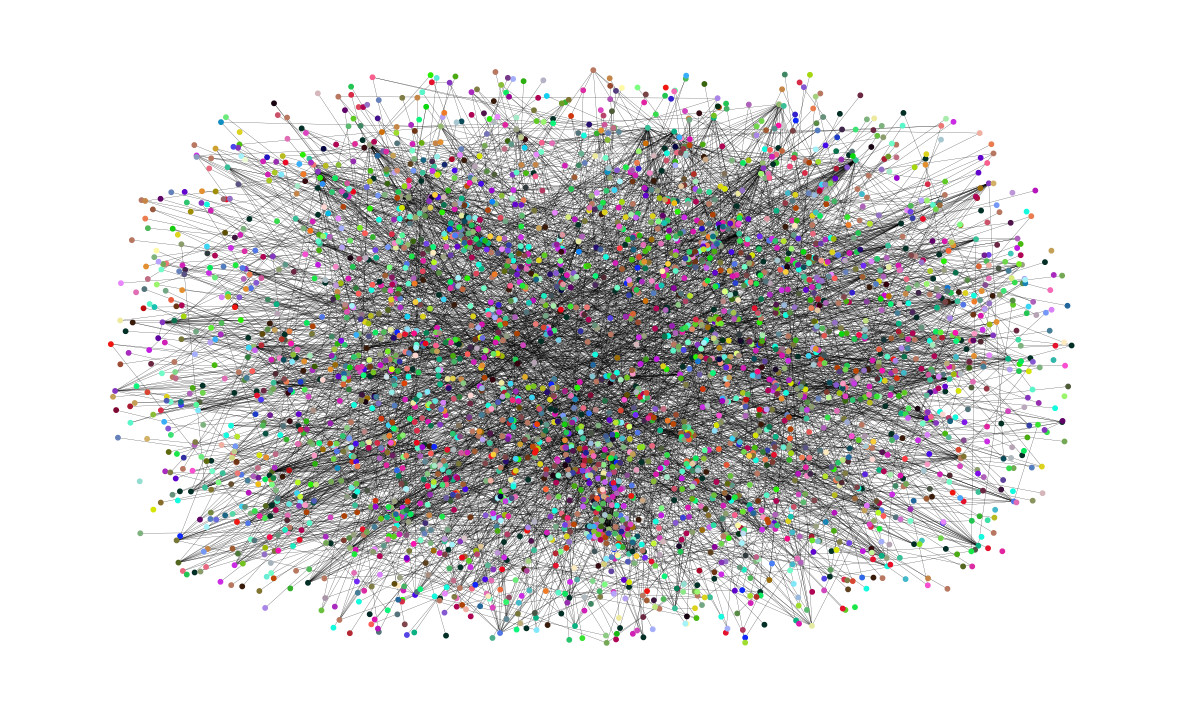

In [26]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors.values()
)

In [19]:
import matplotlib.pyplot as plt
g = ig.Graph.Load("outputs/FlashWeave/network_cultivar-alpha=0.05.gml", format='gml')
g.vs["color"] = ["red" if mv else "blue" for mv in g.vs["mv"]]

In [ ]:
layout = g.layout(layout='auto')

<Axes: >

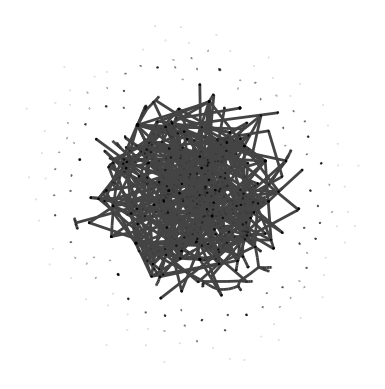

In [20]:
fig, ax = plt.subplots()
ig.plot(g, layout=layout, target=ax, vertex_label=None)